# Reads a single float and calculates nitrate uptake

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import seawater as sw
from soccom_functions import *
import pickle 
import datetime

ModuleNotFoundError: No module named 'seawater'

## Reads float data

In [2]:
#reads float data
#FromBieto/float_data/9099SOOCN_HRQC.nc

file_folder = "./float_data/"
float_number = "9094"

files = sorted(glob.glob(file_folder+"/*"+float_number+"*.nc"))


In [3]:
#help(sorted)
#help(glob)
#help(grids_one_buoy)
#help(pygamma)

In [4]:
#uses the function that reads and grids the data
FLOAT = grids_one_buoy(files[0], display_info = False, DO_ml_crit = 2.5, clear_short = True)

In [5]:
#the gridded data is located in the dictionary FLOAT.gr, and contains the following variables
print(FLOAT.gr.keys())
#some of them are standard and others related to thorpe scales and mixing, and you also have geopotential anomalies (gpa) integrated between 500 and 1500 m (gpa_500_1500)

print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))

dict_keys(['depth', 'date', 'Lon', 'Lat', 'code', 'WMO_code', 'Pressure', 'Temperature', 'Salinity', 'SA', 'CT', 'Sigma_theta', 'gamma_n', 'N2', 'PV', 'Oxygen', 'OxygenSat', 'Nitrate', 'DIC_LIAR', 'TALK_LIAR', 'pCO2_LIAR', 'Chla_corr', 'POC', 'LT', 'mld', 'mld_HT', 'mld_DO', 'LT_ml', 'LT_ov', 'LT_largest_ov', 'size_largest_ov', 'h_largest_ov', 'h_no_ov', 'gpa', 'gpa_500_1500', 'AOU'])
This float is WMO code: 5904469


## Initial plot of the float main variables and position

C:\anaconda\anaconda3\envs\argo\lib\site-packages\matplotlib\contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\anaconda\anaconda3\envs\argo\lib\site-packages\matplotlib\contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


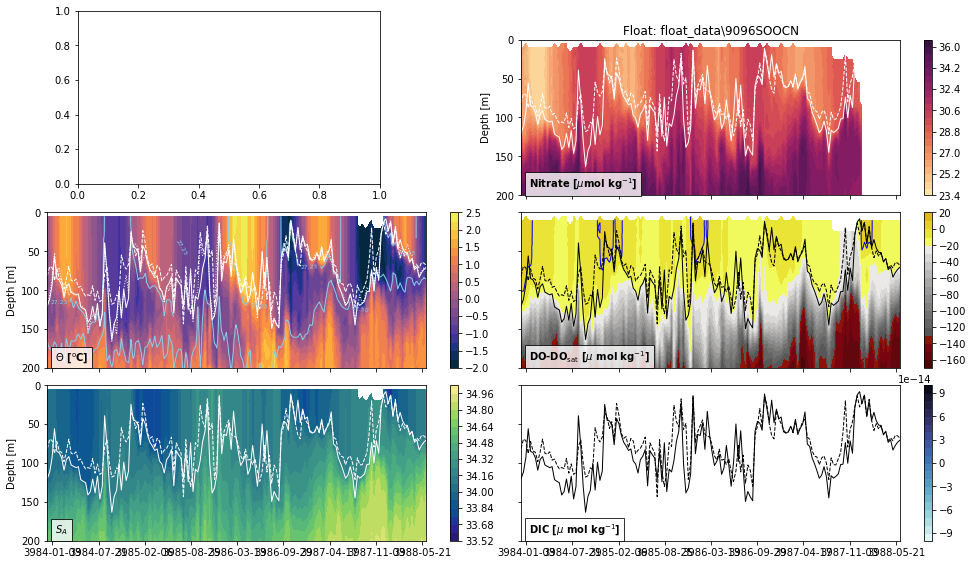

In [6]:
#with this command you can have an overview of the float data 
FLOAT.plots_map_main_variables(shows = True, saves = False, ylim=  (200,0))
#FLOAT.plots_mixing_layer_profile(20, show = True)

## Nitrate uptake

In [7]:
#help()

Deepest mixed layer: 200 m
-56.2844375

--------------------------------
YEAR		 NEP	 <NEP>
		 [mol/m2/yr]
--------------------------------
2014-2015	 nan	 nan
2015-2016	 4.25	 2.44
2016-2017	 4.28	 2.93
2017-2018	 3.00	 2.04
2018-2019	 2.03	 0.89
2019-2020	 nan	 nan
--------------------------------


<ipython-input-7-f544a58adaf0>:20: RuntimeWarning: Mean of empty slice
  dint_Nitrate = np.nanmean(FLOAT.gr["Nitrate"][:jh,:], axis = 0)*(H-25)*(1027/1e6)


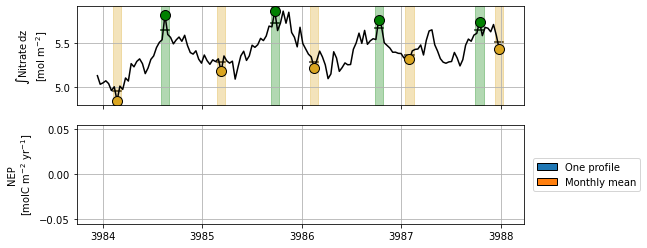

In [7]:
#first I convert the numerical date to a datetime format so I can get the month and year vectors
RCN = 106/16. # Redfield ratio

nt = FLOAT.gr["date"].size
dateDT = convert_time_to_date( FLOAT.gr["date"] )
year = np.full( nt, np.nan ) # make an array of nans, same size as nt (float dates) 
month = np.full(nt, np.nan) # make an array of nans, same size as nt (float dates) 
for i in range(nt):
    year[i] = dateDT[i].year # fill arrays with year
    month[i] = dateDT[i].year # fill arrays with... month? year?... check

H = 200 #np.nanmax(FLOAT.gr["mld"]) # calculates the maximum ML
##### YOU COULD OVER-RIDE IT BY UN-COMMENTING
# = 200
print("Deepest mixed layer: %1.0f m"%(H)) # think the % represents what value to put in so there's no breaks in the ""
jh = np.where( FLOAT.gr["depth"]>= H)[0][0] # gets the depth index for the maximum mixed layer
print(np.nanmean(FLOAT.gr["Lat"]))

#depth integrated nitrate
dint_Nitrate = np.nanmean(FLOAT.gr["Nitrate"][:jh,:], axis = 0)*(H-25)*(1027/1e6)
#by multiplying by density ~1027 and dividing by 1e6 I get units mol m-2

#for each year calculates the maximum and minimum
Uyear = np.unique(year)
nyr = Uyear.size
date_nit_min = np.full(nyr, np.nan)
date_nit_max = np.full(nyr, np.nan)
nit_max = np.full(nyr, np.nan)
nit_min = np.full(nyr, np.nan)
nit_max_month_avg = np.full(nyr, np.nan)
nit_min_month_avg = np.full(nyr, np.nan)
for i, yr in enumerate(Uyear):
    start_summer = datetime.datetime(int(yr),12,1,0,0).toordinal()
    end_summer = datetime.datetime(int(yr)+1,4,1,0,0).toordinal()
    it_summer = np.where( (FLOAT.gr["date"]>= start_summer) & (FLOAT.gr["date"]<= end_summer) )[0]
    if it_summer.size > 0:
        if np.sum(np.isfinite(dint_Nitrate[it_summer]))>0:
            imin_nit = it_summer[ np.nanargmin( dint_Nitrate[it_summer] ) ]
            date_nit_min[i] = FLOAT.gr["date"][imin_nit]  
            nit_min[i] =np.nanmin( dint_Nitrate[it_summer])
            ii_min_month = np.where( np.abs(FLOAT.gr["date"] - FLOAT.gr["date"][imin_nit]  )<15 )[0]
            nit_min_month_avg[i] =np.nanmean( dint_Nitrate[ii_min_month])
        
    start_winter = datetime.datetime(int(yr),5,1,0,0).toordinal()
    end_winter = datetime.datetime(int(yr),12,1,0,0).toordinal()
    it_winter = np.where( (FLOAT.gr["date"]>= start_winter) & (FLOAT.gr["date"]<= end_winter) )[0]
    if it_winter.size > 0:
        if np.sum(np.isfinite(dint_Nitrate[it_winter]))>0:
            imax_nit = it_winter[ np.nanargmax( dint_Nitrate[it_winter] ) ]
            date_nit_max[i] = FLOAT.gr["date"][imax_nit]  
            nit_max[i] = np.nanmax( dint_Nitrate[it_winter])
            ii_max_month = np.where( np.abs(FLOAT.gr["date"] - FLOAT.gr["date"][imax_nit]  )<15 )[0]
            nit_max_month_avg[i] =np.nanmean( dint_Nitrate[ii_max_month])

#calculates net ecosystem production (molC m-2 yr-1)
NEP = (nit_max - nit_min)*RCN
#from the monthly means
NEP_avg = (nit_max_month_avg - nit_min_month_avg)*RCN
#gets the date around the depletion
date_year = 0.5*(date_nit_min +date_nit_max )


#Plots the results 
fig, ax = plt.subplots(2,1,figsize = (8,4), sharex = True)
ax[0].plot( FLOAT.gr["date"], dint_Nitrate, "k" )
l1,=ax[0].plot(date_nit_min, nit_min,"o", ms = 10, mec = "k", color = "goldenrod")
l2,=ax[0].plot(date_nit_max, nit_max,"o", ms = 10, mec = "k", color = "green")
for i in range(nyr):
    ax[0].plot([date_nit_min[i]-15,date_nit_min[i]+15], [nit_min_month_avg[i],nit_min_month_avg[i]], color = "k", zorder = -1)
    ax[0].plot([date_nit_max[i]-15,date_nit_max[i]+15], [nit_max_month_avg[i],nit_max_month_avg[i]], zorder = -1, color = "k")
yl = ax[0].get_ylim()
for i in range(nyr):
    ax[0].fill_between( [date_nit_min[i]-15,date_nit_min[i]+15], y1 = yl[0], y2 = yl[1], color = l1.get_color(), alpha = 0.3 )
    ax[0].fill_between( [date_nit_max[i]-15,date_nit_max[i]+15], y1 = yl[0], y2 = yl[1], color = l2.get_color(), alpha = 0.3 )

ax[0].set_ylim(yl)
ax[0].set_ylabel( "$\\int \\mathrm{Nitrate}\, \\rm d z$\n[mol m$^{-2}$]" )
ax[0].grid(True)

ax[1].bar( date_year-20, NEP, width = 50, ec = "k", label = "One profile"  )
ax[1].bar( date_year+20, NEP_avg, width = 50, ec = "k", label = "Monthly mean" )
ax[1].set_ylabel("NEP\n[molC m$^{-2}$ yr$^{-1}$]")
ax[1].legend(loc = "center left", bbox_to_anchor = (1.01,0.5))
formatter = mdates.DateFormatter("%Y") ### formatter of the date
locator = mdates.YearLocator() ### where to put the labels
ax[1].xaxis.set_major_locator(locator)
ax[1].xaxis.set_major_formatter(formatter)
ax[1].grid(True)

print( "\n--------------------------------\nYEAR\t\t NEP\t <NEP>" )
print("\t\t [mol/m2/yr]")
print( "--------------------------------")
for i in range(nyr):
    print("%d-%d\t %1.2f\t %1.2f"%(Uyear[i],Uyear[i]+1, NEP[i], NEP_avg[i])  )
print( "--------------------------------")

As you see the averages are slightly different, not sure why, probably due to a combination of interpolation for gridding the nitrate and also the vertical integration, but the overall values and the general patterns are the same



matplotlib 2.2.5